# Piecewise Exact Method

### Time Discretisation

In the previous lecture we explored the impact of force signal segmentation and showed that care must be taken not to over simplify (under-segment) the force signal. In fact a safe approach is to utilise all available force data in your simulation.

Care must also be taken when selected a suitable timestep, also known as time discretisation. If too large a timestep is selected, our assumption of a linear change in force magnitude will become less accurate. Again we can demonstrate the influence of varying the timestep by carrying out a sensitivity analysis. 

We'll start by generating a function that will generate time and force vectors from a sine wave with varying timestep. First import dependencies and define constants.

In [1]:
# DEPENDENCIES
import math
import numpy as np
import matplotlib.pyplot as plt

# SYSTEM CONSTANTS
m = 1000 #(kg) Mass
k = 20000 #(N/m) Stiffness
xi = 0.05 # Damping ratio 
P = 750 # (N) Force magnitude
f = 1 # (Hz) Forcing frequency
pi = math.pi
omega_n = math.sqrt(k/m) #(rads/sec) Undamped natural frequency
f_n = omega_n/(2*pi) #(Hz) Undamped natural frequency
omega_d = omega_n*math.sqrt(1-xi**2) #Damped natural frequency
omega = 2*pi*f #(rads/sec) Forcing frequency
beta = omega/omega_n # Frequency ratio
tmax = 100 #(sec) The max time

### Function to generate time and force vectors

In [2]:
def generateVectors(timeStep):
    delta_t = timeStep
    nPoints = tmax/delta_t #Number of equally spaced data points
    t = np.linspace(0,tmax, int(nPoints)) # Time vector
    F_sine = P*np.sin(omega*t) #Force vector
    return [t,F_sine]

Call the function several times to generate data

In [3]:
t1, f1 = generateVectors(0.1)
t2, f2 = generateVectors(0.05)
t3, f3 = generateVectors(0.01)
t4, f4 = generateVectors(0.005)

### Define a function to calculate dynamic response (from previous lecture)
Note that this time we're taking timestep into our calculateResponse function as a parameter.

In [4]:
# Define function to calculate the response
def calculateResponse(tVector, fVector, timeStep):  
    delta_t = timeStep
    nPoints = len(tVector)
    #Constants
    A = math.e**(-xi*omega_n*delta_t)*((xi/(math.sqrt(1-(xi**2))))*np.sin(omega_d*delta_t)+np.cos(omega_d*delta_t))
    B = math.e**(-xi*omega_n*delta_t)*((1/omega_d*np.sin(omega_d*delta_t)))
    C = (1/k)*(((2*xi)/(omega_n*delta_t)) + math.e**(-xi*omega_n*delta_t)*((((1-2*(xi**2))/(omega_d*delta_t))-(xi/(math.sqrt(1-(xi**2)))))*math.sin(omega_d*delta_t)-(1+((2*xi)/(omega_n*delta_t)))*np.cos(omega_d*delta_t)))
    D = (1/k)*(1-((2*xi)/(omega_n*delta_t))+math.e**(-xi*omega_n*delta_t)*(((2*(xi**2)-1)/(omega_d*delta_t))*np.sin(omega_d*delta_t)+((2*xi)/(omega_n*delta_t))*np.cos(omega_d*delta_t)))

    A1 = -math.e**(-xi*omega_n*delta_t)*((omega_n/(math.sqrt(1-(xi**2))))*np.sin(omega_d*delta_t))
    B1 = math.e**(-xi*omega_n*delta_t)*(np.cos(omega_d*delta_t)-((xi)/(math.sqrt(1-(xi**2))))*np.sin(omega_d*delta_t))
    C1 =(1/k)*(-(1/delta_t)+math.e**(-xi*omega_n*delta_t)*((((omega_n)/(math.sqrt(1-(xi**2))))+((xi)/(delta_t*math.sqrt(1-(xi**2)))))*np.sin(omega_d*delta_t)+(1/delta_t)*np.cos(omega_d*delta_t)))
    D1 =(1/k)*((1/delta_t)-(math.e**(-xi*omega_n*delta_t)/delta_t)*((xi/(math.sqrt(1-(xi**2))))*np.sin(omega_d*delta_t)+np.cos(omega_d*delta_t))) 

    #INITIAL CONDITIONS
    x0=0 
    v0=0

    pos = [] #Initialise array to hold position
    vel = [] #Initialise array to hold velocity
    
    #MAIN LOOP
    for n, timestep in enumerate(tVector):
        timestep = round(timestep,3) #The current time

        #Calculate the force slope
        if n<nPoints-1:
            Fn = fVector[n]
            Fnp1 = fVector[n+1]
        else:
            Fn = fVector[n]
            Fnp1 = 0

        curPos = (A*x0) + (B*v0) + (C*Fn) + (D*Fnp1)
        curVel = (A1*x0) + (B1*v0)+ (C1*Fn) + (D1*Fnp1)

        pos.append(curPos)
        vel.append(curVel)

        x0 = curPos;
        v0 = curVel;
    
    return pos

### Call the function to calculate response with different timesteps

In [5]:
Pos1 = calculateResponse(t1,f1, 0.1)
Pos2 = calculateResponse(t2,f2,0.05)
Pos3 = calculateResponse(t3,f3, 0.01)
Pos4 = calculateResponse(t4,f4, 0.005)

### Plot the results

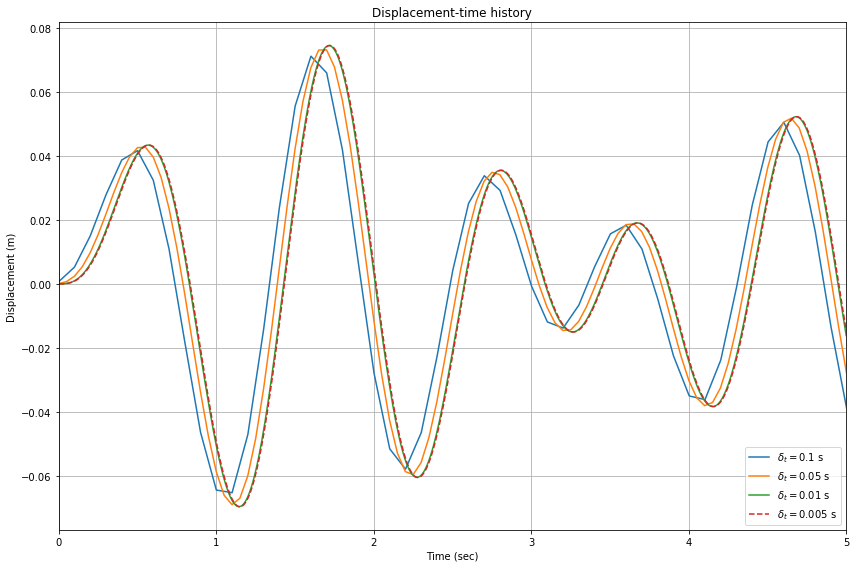

In [6]:
fig, axes = plt.subplots(figsize=(12,8),nrows=1,ncols=1) 
axes.plot(t1,Pos1, label='$\delta_t = 0.1$ s')
axes.plot(t2,Pos2, label='$\delta_t = 0.05$ s')
axes.plot(t3,Pos3, label='$\delta_t = 0.01$ s')
axes.plot(t4,Pos4,'--', label='$\delta_t = 0.005$ s')
axes.set_xlim([0,5])
axes.set_xlabel('Time (sec)')
axes.set_ylabel('Displacement (m)')
axes.set_title('Displacement-time history')
axes.grid()
axes.legend(loc='lower right')
plt.tight_layout()
fig.savefig('timestep.png')

### Some observations
<ul>
<li>We can see that as the timestep is reduced the structural behaviour converges and no further improvement is gained by further timestep reduction.
</ul>
<ul>
<li>Based on this analysis, a sensible timestep would be $\delta t = 0.01$ s. This is because no significant improvement is observed when the timestep is halved, doubling the number of calculations in the simulation. 
</ul>
<ul>
<li>In general, with the application of any numerical solution technique, it is critical that the parameter space is explored to confirm the a suitable simulation timestep (time discretisation) and force discretisation is selected. 
</ul>
<ul>
<li>For analyses involving spacial parameters (e.g. finite element analysis) or multi-degree of freedom dynamic analysis, space discretisation must also be considered but this is beyond the scope of this course. 
</ul>